# __S2FFT CUDA Implementation__
---

[![colab image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/astro-informatics/s2fft/blob/main/notebooks/JAX_HEALPix_frontend.ipynb)

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

# Install s2fft and data if running on google colab.
if IN_COLAB:
    !pip install s2fft &> /dev/null

Short comparaison between the pure JAX implementation and the CUDA implementation of the S2FFT algorithm.

In [2]:
import jax
from jax import numpy as jnp
import argparse
import time

jax.config.update("jax_enable_x64", True)

from s2fft.utils.healpix_ffts import  healpix_fft_jax, healpix_ifft_jax, healpix_fft_cuda, healpix_ifft_cuda

import numpy as np
import s2fft 

from jax._src.numpy.util import promote_dtypes_complex


In [4]:
def run_fwd_test(nside):
    L = 2 * nside 

    total_pixels = 12 * nside**2
    arr = jax.random.normal(jax.random.PRNGKey(0), (total_pixels, ))

    start = time.perf_counter()
    cuda_res = healpix_fft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start

    start = time.perf_counter()
    cuda_res = healpix_fft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    start = time.perf_counter()
    jax_res = healpix_fft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_jit_time = end - start

    start = time.perf_counter()
    jax_res = healpix_fft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    method = "jax_healpy"
    sampling = "healpix"
    (arr,) = promote_dtypes_complex(arr)
    start = time.perf_counter()
    flm = s2fft.forward(arr, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    healpy_jit_time = end - start

    start = time.perf_counter()
    flm = s2fft.forward(arr, L, nside=nside, sampling=sampling, method=method).block_until_ready()
    end = time.perf_counter()
    healpy_run_time = end - start

    print(f"For nside {nside}")
    print(f" -> FWD")
    print(f" -> -> cuda_jit_time: {cuda_jit_time}, cuda_run_time: {cuda_run_time}")
    print(f" -> -> jax_jit_time: {jax_jit_time}, jax_run_time: {jax_run_time}")
    print(f" -> -> healpy_jit_time: {healpy_jit_time}, healpy_run_time: {healpy_run_time}")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time , healpy_jit_time, healpy_run_time


def run_bwd_test(nside):

    L = 2 * nside
    ftm_shape = (4 * nside - 1, 2 * L)
    ftm_size = ftm_shape[0] * ftm_shape[1]

    arr = jax.random.normal(jax.random.PRNGKey(0), ftm_shape)

    start = time.perf_counter()
    cuda_res = healpix_ifft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_jit_time = end - start

    start = time.perf_counter()
    cuda_res = healpix_ifft_cuda(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    cuda_run_time = end - start

    start = time.perf_counter()
    jax_res = healpix_ifft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()

    jax_jit_time = end - start
    
    start = time.perf_counter()
    jax_res = healpix_ifft_jax(arr, L, nside,reality=False).block_until_ready()
    end = time.perf_counter()
    jax_run_time = end - start

    method = "jax_healpy"
    sampling = "healpix"
    rng = np.random.default_rng(23457801234570)
    flm = s2fft.utils.signal_generator.generate_flm(rng, L)

    start = time.perf_counter()
    f = s2fft.inverse(flm, L, nside=nside, sampling=sampling, method=method)
    end = time.perf_counter()
    healpy_jit_time = end - start

    start = time.perf_counter()
    f = s2fft.inverse(flm, L, nside=nside, sampling=sampling, method=method)
    end = time.perf_counter()
    healpy_run_time = end - start

    print(f"For nside {nside}")
    print(f" -> BWD")
    print(f" -> -> cuda_jit_time: {cuda_jit_time}, cuda_run_time: {cuda_run_time}")
    print(f" -> -> jax_jit_time: {jax_jit_time}, jax_run_time: {jax_run_time}")
    print(f" -> -> healpy_jit_time: {healpy_jit_time}, healpy_run_time: {healpy_run_time}")

    return cuda_jit_time , cuda_run_time, jax_jit_time, jax_run_time , healpy_jit_time, healpy_run_time

In [5]:
jax.clear_caches()

In [17]:
fwd_times = []
bwd_times = []
nsides = [4 , 8, 16, 32]
for nside in nsides:
    fwd_times.append(run_fwd_test(nside))
    bwd_times.append(run_bwd_test(nside))

For nside 4
 -> FWD
 -> -> cuda_jit_time: 0.0005623459999242186, cuda_run_time: 0.0002589869998246286
 -> -> jax_jit_time: 0.00023036399988995981, jax_run_time: 0.0001553519998651609
 -> -> healpy_jit_time: 0.003654524000012316, healpy_run_time: 0.00570670499996595
For nside 4
 -> BWD
 -> -> cuda_jit_time: 0.0003901920001680992, cuda_run_time: 0.0005790029999843682
 -> -> jax_jit_time: 0.0004877889998624596, jax_run_time: 0.00042751199998747325
 -> -> healpy_jit_time: 0.004256186000020534, healpy_run_time: 0.004342149000194695
For nside 8
 -> FWD
 -> -> cuda_jit_time: 0.0005613310001990612, cuda_run_time: 0.0010512769999877492
 -> -> jax_jit_time: 0.0015170009999110334, jax_run_time: 0.0028007529999740655
 -> -> healpy_jit_time: 0.01888900099993407, healpy_run_time: 0.020618764999881023
For nside 8
 -> BWD
 -> -> cuda_jit_time: 0.0009404789998370688, cuda_run_time: 0.0007269820000601612
 -> -> jax_jit_time: 0.001543406999871877, jax_run_time: 0.0008582420000493585
 -> -> healpy_jit_tim

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.plotting_context("poster")
sns.set(font_scale=1.4)


def plot_times(title, nsides, chrono_times):

    # Extracting times from the chrono_times
    cuda_jit_times = [times[0] for times in chrono_times]
    cuda_run_times = [times[1] for times in chrono_times]
    jax_jit_times = [times[2] for times in chrono_times]
    jax_run_times = [times[3] for times in chrono_times]
    healpy_jit_times = [times[4] for times in chrono_times]
    healpy_run_times = [times[5] for times in chrono_times]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    f2 = lambda a: np.log2(a)
    g2 = lambda b: b**2


    # Plot for JIT times
    ax1.plot(nsides, cuda_jit_times, 'g-o', label='ours')
    ax1.plot(nsides, jax_jit_times, 'b-o', label='s2fft base')
    ax1.plot(nsides, healpy_jit_times, 'r-o', label='Healpy')
    ax1.set_title('Compilation Times (first run)')
    ax1.set_xlabel('nside')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('function', functions=(f2, g2))
    ax1.set_xticks(nsides)
    ax1.set_xticklabels(nsides)
    ax1.legend()
    ax1.grid(True, which="both", ls="--")

    # Plot for Run times
    ax2.plot(nsides, cuda_run_times, 'g-o', label='ours')
    ax2.plot(nsides, jax_run_times, 'b-o', label='s2fft base')
    ax2.plot(nsides, healpy_run_times, 'r-o', label='Healpy')
    ax2.set_title('Execution Times')
    ax2.set_xlabel('nside')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('function', functions=(f2, g2))
    ax2.set_xticks(nsides)
    ax2.set_xticklabels(nsides)
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Set the overall title for the figure
    fig.suptitle(title, fontsize=16)

    # Show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to make space for the suptitle
    plt.show()

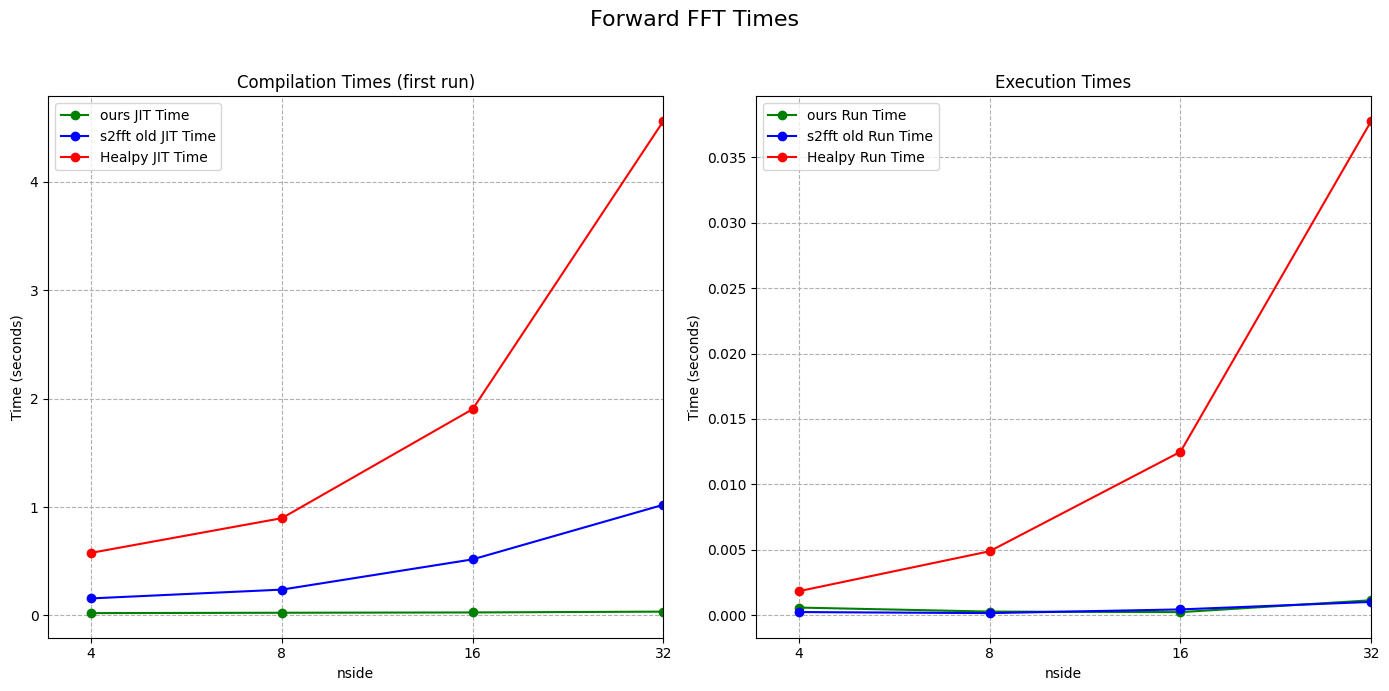

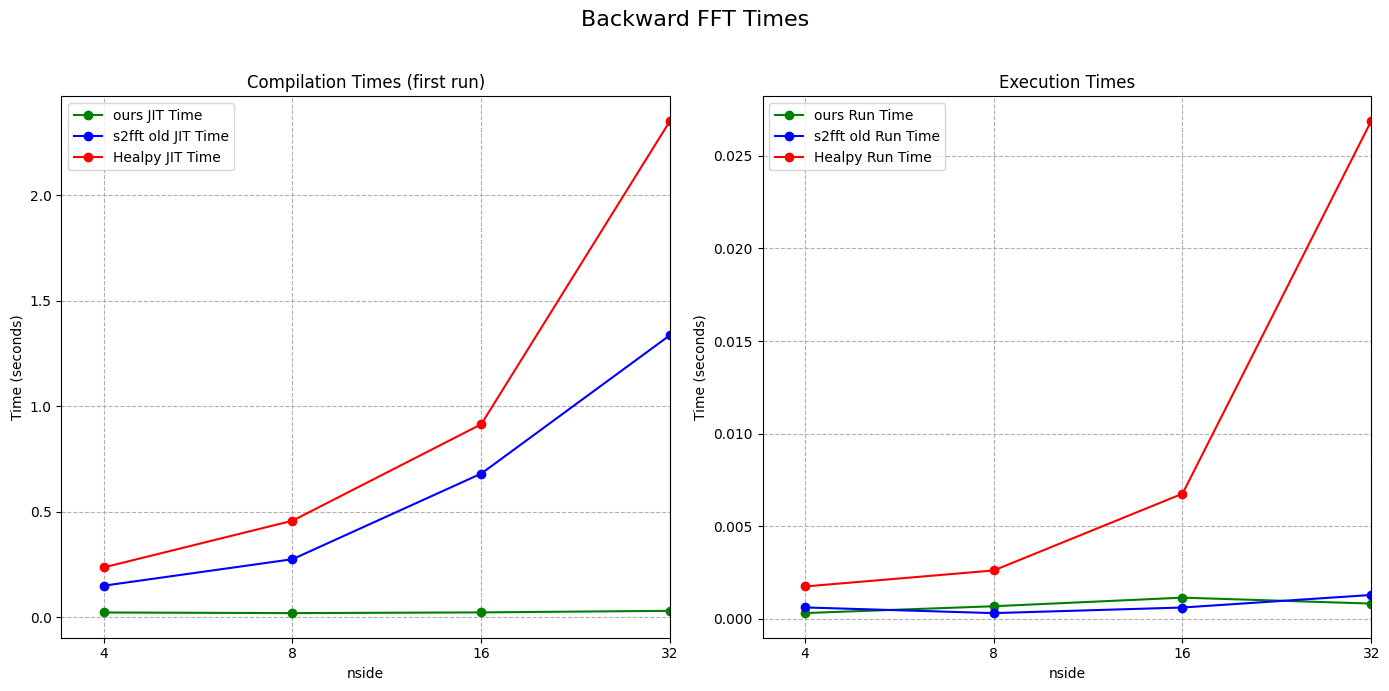

In [12]:

plot_times("Forward FFT Times", nsides, fwd_times)
plot_times("Backward FFT Times", nsides, bwd_times)